<h1>Sepsis Survival Minimal Clinical Records</h1>

<h3>Context & Motivation</h3>

<p>The primary objective of this project is to develop and validate an interpretable machine learning model—specifically, a Logistic Regression model—capable of predicting a negative patient outcome (30-day mortality) in a healthcare support application.

<p>Given the time-sensitive and critical nature of Sepsis, where every hour of delayed treatment increases mortality risk, the model serves as an early alert system. By using minimal clinical records, the application aims to flag patients at the highest risk of mortality. This early warning enables healthcare providers to prioritize interventions, allocate critical resources, and apply life-saving protocols more efficiently, ultimately supporting evidence-based clinical decision-making and improving patient survival rates.

<h3>Problem Definition</h3>

<p>Sepsis is a life-threatening condition defined as organ dysfunction caused by a dysregulated host response to infection. It is a global health crisis characterized by high incidence, severe morbidity, and high mortality.

<h3>Expected Social Impact</h3>

<h4>SDG 3: Good Health and Well-being</h4>

<p>The project directly addresses the global imperative to improve health outcomes, particularly by tackling one of the most common causes of preventable death in hospital settings.
<ul>
<li>SDG 3.2: By 2030, end preventable deaths of newborns and children under 5 years of age.</li>
<p>Sepsis is a major killer of children; models that increase early detection can directly reduce pediatric mortality.
<li>SDG 3.4: By 2030, reduce by one third premature mortality from non-communicable diseases through prevention and treatment.</li>
<p>While Sepsis is an infectious process, reducing its mortality contributes directly to the overall reduction of premature, avoidable deaths in the healthcare system.
<li>SDG 3.d:Strengthen the capacity of all countries... for early warning, risk reduction and management of national and global health risks.</li>
<p>The predictive model acts as an AI-powered early warning system, enhancing the capacity of healthcare providers to manage Sepsis risk.

------------------------

<h2>Importing Dataset</h2>

<h3>Import Library</h3>

In [74]:
#import libraries 

import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate, StratifiedKFold
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, PowerTransformer
from statsmodels.formula.api import logit
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, recall_score, f1_score, roc_auc_score, roc_curve, auc,precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize


#import Functions_EDA.py to use their functions

from Functions_EDA import *

<h4>Dataset Description</h4>

This dataset is designed for binary classification, with the primary goal of predicting the survival outcome of patients diagnosed with or at risk of sepsis using a minimal set of clinical features that are easy to collect quickly.
<br>
Source: UCI Machine Learning Repository (Originally published in Scientific Reports by Chicco and Jurman, 2020).<br>
Avaliable here: https://archive.ics.uci.edu/dataset/827/sepsis+survival+minimal+clinical+records
<h5>Key Features and Design Principles:</h5>
<ul>
<li>hospital_outcome_1alive_0dead: Target</li>
<p>The survival status of the patient after approximately 9 days of admission.
<li>age_years: Feature</li>
<p>Age of the patient.
<li>sex_0male_1female: Feature</li>
<p>Gender of the patient.
<li>episode_number: Feature</li>
<p>Number of prior septic episodes the patient has experienced.
</ul>


<h3>Import Database</h3>

In [2]:
#Import all dataset

df_1 = pd.read_csv("s41598-020-73558-3_sepsis_survival_primary_cohort.csv")
df_2 = pd.read_csv("s41598-020-73558-3_sepsis_survival_study_cohort.csv")
df_3 = pd.read_csv("s41598-020-73558-3_sepsis_survival_validation_cohort.csv")

#Combine all dataset into one
df= pd.concat([df_1,df_2,df_3],ignore_index=True)

In [3]:
#plot df:

df.head()

,age_years,sex_0male_1female,episode_number,hospital_outcome_1alive_0dead
0,21,1,1,1
1,20,1,1,1
2,21,1,1,1
3,77,0,1,1
4,72,0,1,1


<h4>Rename Columns for better interpretability</h4>

In [4]:
#The columns will be renamed for better interpretebility 

df = df.rename(columns={
    "age_years":"Age",
    "sex_0male_1female":"Female",
    "episode_number":"n_prior_sepsis",
    "hospital_outcome_1alive_0dead":"Output"
})

<h4>Quick Overview</h4>

In [5]:
# Overview about the Dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129392 entries, 0 to 129391
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   Age             129392 non-null  int64
 1   Female          129392 non-null  int64
 2   n_prior_sepsis  129392 non-null  int64
 3   Output          129392 non-null  int64
dtypes: int64(4)
memory usage: 3.9 MB


<p> There is no Missing Data in this Dataset

In [6]:
#Quick descriptive statistics

df.describe()

,Age,Female,n_prior_sepsis,Output
count,129392.000000,129392.000000,129392.000000,129392.000000
mean,64.170057,0.470075,1.356081,0.909307
std,23.644353,0.499106,0.756492,0.287174
min,0.000000,0.000000,1.000000,0.000000
25%,53.000000,0.000000,1.000000,1.000000
50%,70.000000,0.000000,1.000000,1.000000
75%,82.000000,1.000000,1.000000,1.000000
max,100.000000,1.000000,5.000000,1.000000


In [7]:
#Check which values ​​each of the columns has

column_list = df.columns

for column in column_list:
    unique_val = df[column].unique()
    print(f"Unique Values in {column}: {unique_val}")

Unique Values in Age: [ 21  20  77  72  83  74  69  53  82  75  45  56  46  48  40  39  70  47
  27  11  91   7  79  84  16  73  17  18  63  88  89  76  41  66  80  62
  59  55  68  33  71   8  58  78  51  43  44  60  86  61  67  57  81  49
  64  25  65  42  36  38  85  24  19  37  35   6  50  87  54  29  12  10
  23  52   9  15  31  92  28  30  13  94  90  26  32  95   5  93  34  96
  22  97  98 100  14   4  99   3   2   1   0]
Unique Values in Female: [1 0]
Unique Values in n_prior_sepsis: [1 2 3 4 5]
Unique Values in Output: [1 0]


<p>The columns Female and Output are Binary.
<p>The columns Age and n_prior_sepsis are continuous.

<h4>Duplicated Data</h4>

In [8]:
# check for duplicated data:

check_duplicated(df)

('Duplicate rows found:',
         Age  Female  n_prior_sepsis  Output
 0        21       1               1       1
 1        20       1               1       1
 2        21       1               1       1
 3        77       0               1       1
 4        72       0               1       1
 ...     ...     ...             ...     ...
 129387   47       0               1       1
 129388   50       0               1       0
 129389   62       0               1       1
 129390   58       0               1       0
 129391   55       1               1       1
 
 [129280 rows x 4 columns])

<p> Altough the Database has a lot of duplicated data, I choose to keep those inputs, once they are probably a individual real inputs and not an error. That way, the frequency of those duplicated data might also be relevant for the model.

---------------

<h2>Pre-Processing</h2>

<p>In order to prevent the models from learning through test data, the data will be split into training and test data.

In [9]:
#Define Features:
target = "Output"
y = df[target]
features = [column for column in list(df.columns) if column != target]
X = df[features]

#Split the data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42) #80% for training data and 20% for Test data

#Create 2 DataFrames: one for Training Data and Other for Test Data
df_train = pd.concat([X_train,y_train],axis=1).reindex(X_train.index)
df_test = pd.concat([X_test,y_test],axis=1).reindex(X_test.index)

<h3>Checking for Outliers</h3>

<h5>Numerical Data</h5>

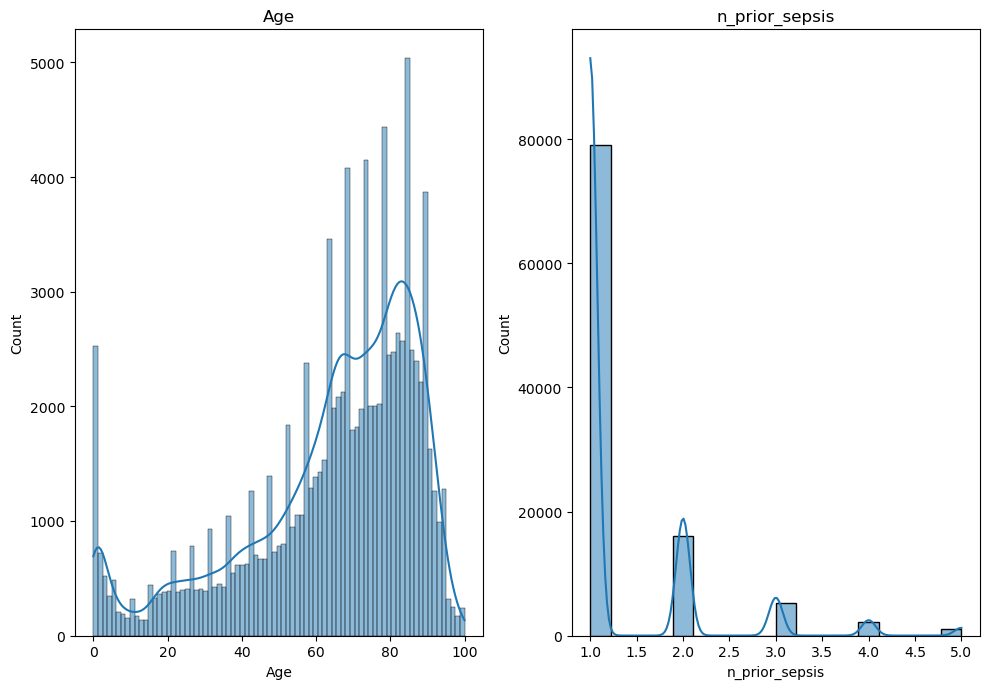

Column  Age  :  5140  outliers from  0  to  9 . Mean:  2.375486381322957
Column  n_prior_sepsis  :  24423  outliers from  2  to  5 . Mean:  2.5158252466936903


In [10]:
#plotting numerical data for Training Data

num_data = ["Age","n_prior_sepsis"]

data_hist(df_train,num_data)

find_iqr_outliers(df_train,num_data)

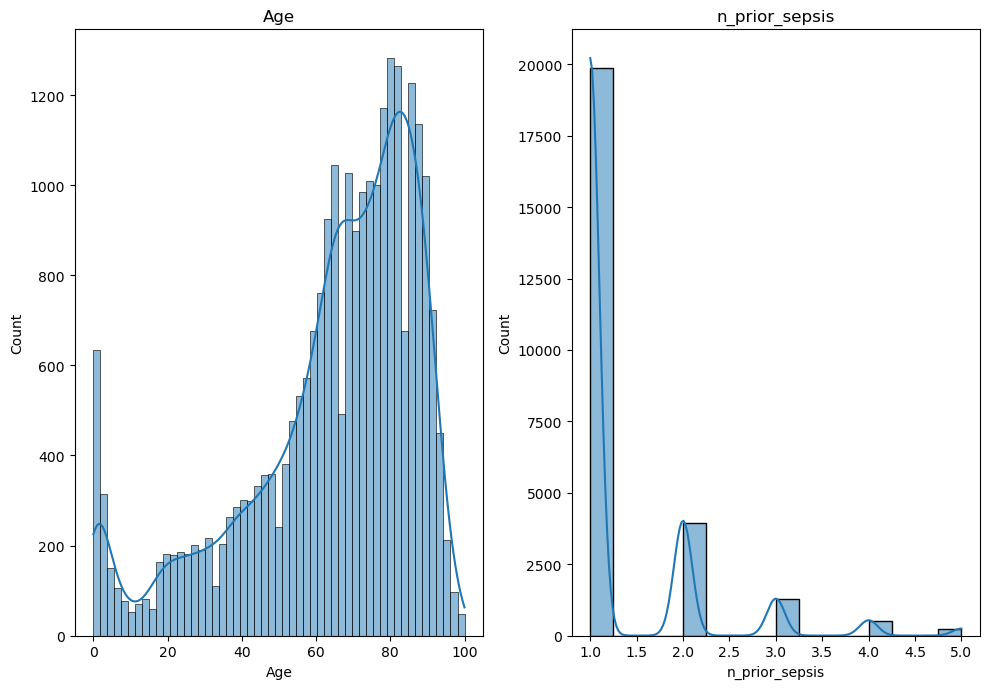

Column  Age  :  1334  outliers from  0  to  11 . Mean:  2.658920539730135
Column  n_prior_sepsis  :  6001  outliers from  2  to  5 . Mean:  2.508581903016164


In [11]:
#plotting numerical data for Test Data

num_data = ["Age","n_prior_sepsis"]

data_hist(df_test,num_data)

find_iqr_outliers(df_test,num_data)

<p>Both Datasets (Training and Test) have similar distribution.
<p>The distribution of Both Features, Age and n_prior_sepsis, are skewed and will be processed in the next step.

<h5>Categorical</h5>

<p>This features is binary, so the frequency will be checked to avoid imbalance.

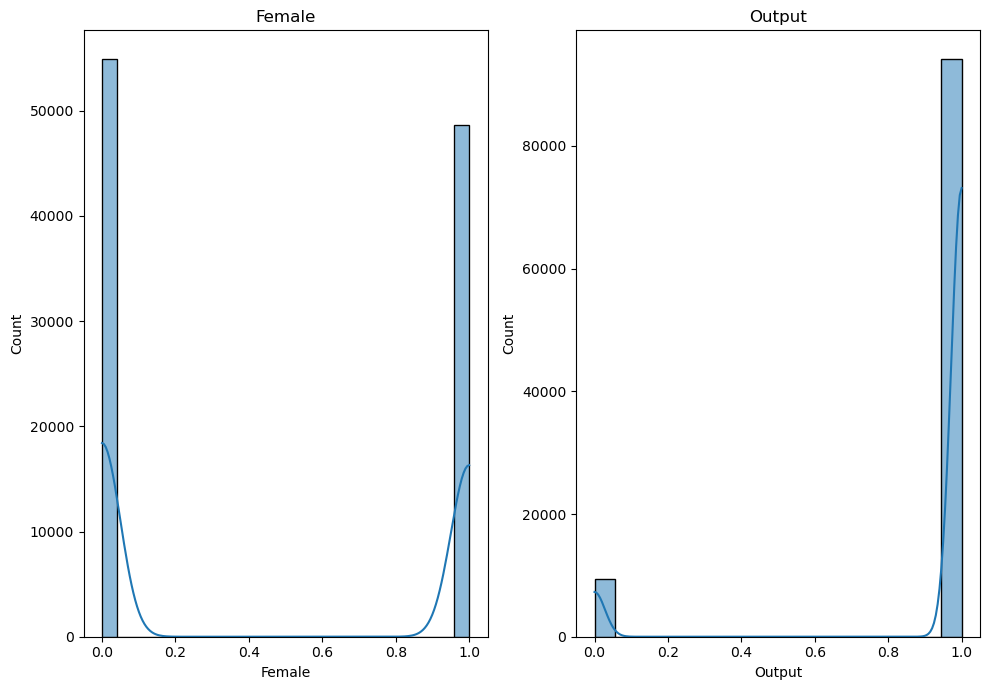

Female :
- 0:54886 (53.02%),
- 1:48627 (46.98%),
Output :
- 1:94118 (90.92%),
- 0:9395 (9.08%),


In [12]:
#check for frequency for training data:

#list with categorical columns 
cat_data = ["Female","Output"]

#Plot Histogram
data_hist(df_train,cat_data)

#print frequency
frequency(df_train,cat_data)

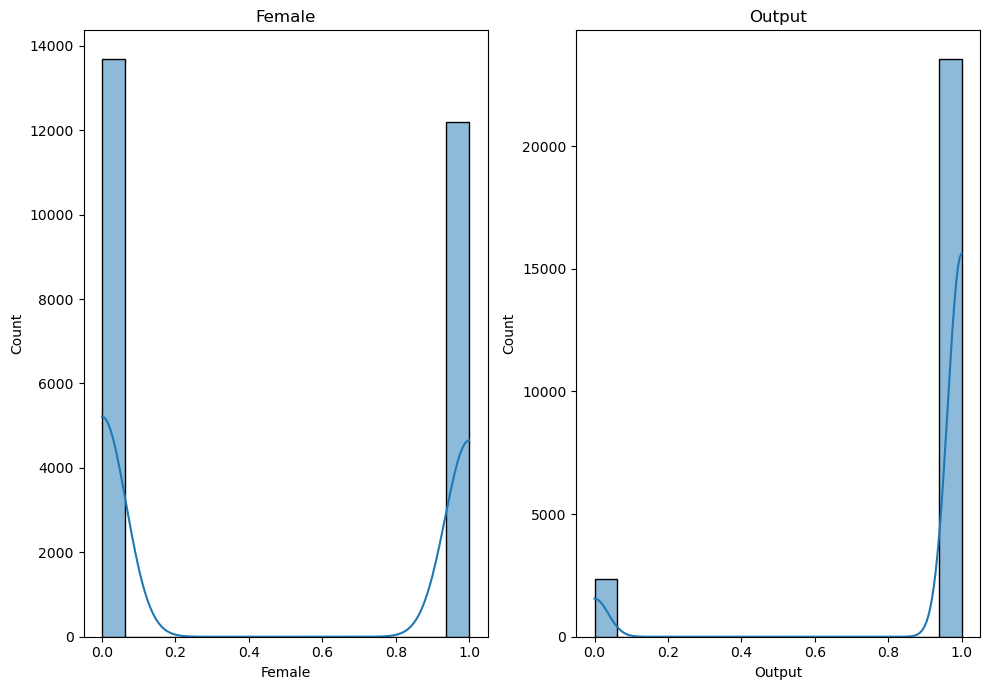

Female :
- 0:13682 (52.87%),
- 1:12197 (47.13%),
Output :
- 1:23539 (90.96%),
- 0:2340 (9.04%),


In [13]:
#Frequency for test data

cat_data = ["Female","Output"]

#Plot Histogram
data_hist(df_test,cat_data)

#print frequency
frequency(df_test,cat_data)

<p>Both Datasets (Training and Test) have same distribution.
<p>Output shows a hight level of imbalance and will be handled in the next steps to improve evaluations metrics.

<h3>Scaling and Normalization</h3>

In [14]:
#Before starting Scaling and Nomralization, I decided to make a copy of my df

df_original_train = df_train.copy()
df_original_test = df_test.copy()

In [15]:
#Age: Age is right-skewed and has few outliers. I decided to use RobustScaler() to scale, because it uses IQR and is not so sensible to outliers.

#Initialize RobustScaler
robust_scaler = RobustScaler()
#Transform Age (just in Training Dataset)
df_train["Age"] = robust_scaler.fit_transform(df_train[["Age"]]) 

#Normalize distribution for Age
pt = PowerTransformer(method='yeo-johnson')  # handles skewed data well
df_train['Age'] = pt.fit_transform(df_train[['Age']])

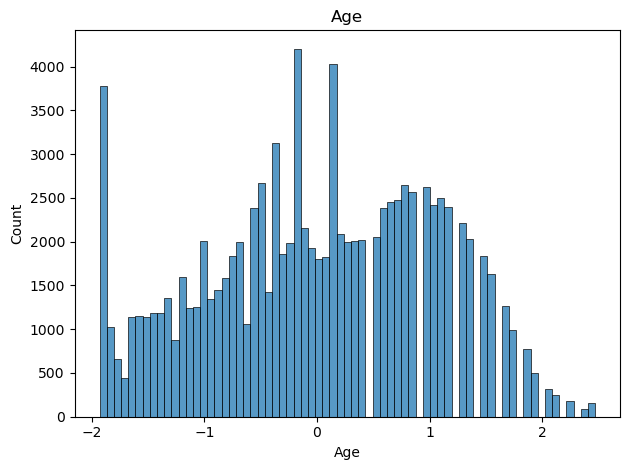

Column  Age  without outliers.


In [16]:
#Plot Age again
data_hist(df_train,["Age"])
find_iqr_outliers(df_train,["Age"])

<p>Now the Distribution is closed to normal and there are no outliers.

In [17]:
#use same transformation to test data
df_test["Age"] = robust_scaler.transform(df_test[["Age"]]) #Scale feature
df_test["Age"] = pt.transform(df_test[["Age"]]) #Normalize distribution

<h3>Transform Features into binary</h3>

In [18]:
#The feature n_prior_sepsis shows more data for 1 prior sepsis than for more than 1. In order to improve the model, I choose to create a new binary column

# Create a binary feature: 1 if > 1 prior sepsis event, 0 if 1 prior sepsis event
df_train['n_prior_sepsis'] = np.where(df_train['n_prior_sepsis'] > 1, 1, 0)

# Create a binary feature: 1 if > 1 prior sepsis event, 0 if 1 prior sepsis event
df_test['n_prior_sepsis'] = np.where(df_test['n_prior_sepsis'] > 1, 1, 0)

<h3>Principal Component Analysis (PCA)</h3>

<p>To visualize and understand how the target data are distributed, I used PCA to plot the data in a 2D manner

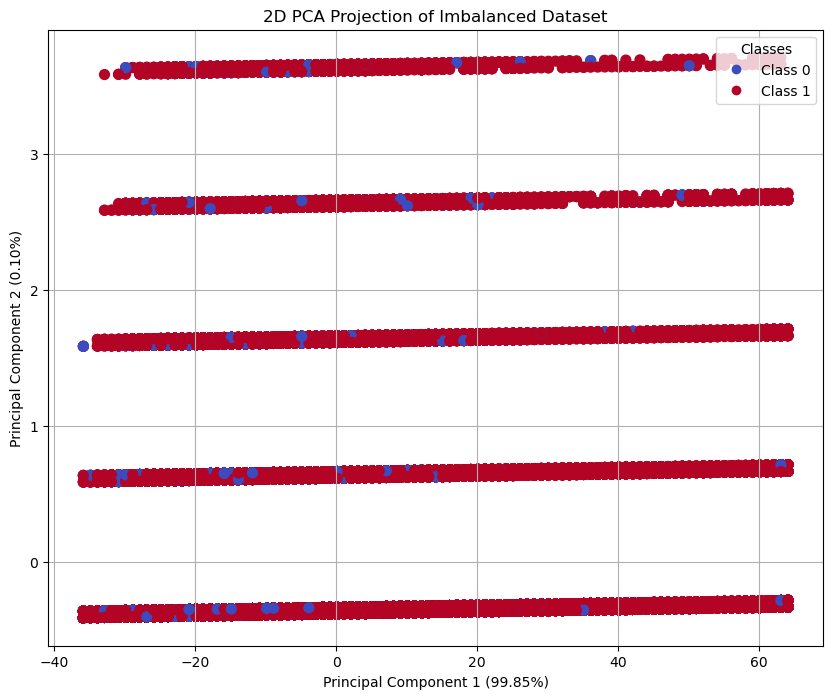

In [19]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# Create a DataFrame for plotting
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])

plt.figure(figsize=(10, 8))

# Scatter plot: color points based on class label 
scatter = plt.scatter(
    pca_df['PC1'], 
    pca_df['PC2'], 
    c=y_train, 
    cmap='coolwarm', 
    s=50 # Set marker size
)

# Create a custom legend 
legend_labels = ['Class 0', 'Class 1']
legend_elements = scatter.legend_elements()

plt.legend(handles=legend_elements[0], 
           labels=legend_labels,
           loc="upper right", 
           title="Classes")

plt.title('2D PCA Projection of Imbalanced Dataset')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.grid(True)
plt.show() # Use plt.show() to display the plot in your local environment

<p>Analyzing the image, it is possible to identify that there are no clear boundaries between the classes, and predictions using classical models would be challenging.
<p>Based on the visualization from the Principal Component Analysis (PCA), the data structure could not support the effective use of traditional oversampling (SMOTE) or undersampling techniques. Therefore, I choose to address the class imbalance through algorithmic modification (class weighting) and test the models on both dataset.

<h3>Imbalance</h3>

<p>To create the Data I used SMOTE and Tomek techniques, in order to balance the data in 55% as Class 1 and 45% as Class 0.

In [ ]:
# N_majority = 50%
# Target N_minority = 50%
target_minority_count = 94118 

# Oversample the minority class (Class 0) ONLY
smote_step = SMOTE(
    sampling_strategy={0: target_minority_count}, # Set Class 0 to target sample number 
    random_state=42
)

# Clean the boundary by removing majority samples (Class 1)
tomek_step = TomekLinks(sampling_strategy='majority')

# Create the Pipeline
pipeline = Pipeline(steps=[('SMOTE', smote_step)])

# Apply the hybrid sampling to the training data
X_resampled, y_resampled = pipeline.fit_resample(X_train, y_train)

#Create new train df:
df_train_balanced = pd.concat([X_resampled,y_resampled],axis=1).reindex(X_resampled.index)

# Check resampled class distribution
print("\n--- After SMOTE + Tomek Links ---")
print(f"Resampled training set shape: {X_resampled.shape}, y_resampled counts: {pd.Series(y_resampled).value_counts()}")


--- After SMOTE + Tomek Links ---
Resampled training set shape: (188236, 3), y_resampled counts: Output
1    94118
0    94118
Name: count, dtype: int64


---------------------------

<h2>Correlation</h2>

<h4>Overview</h4>

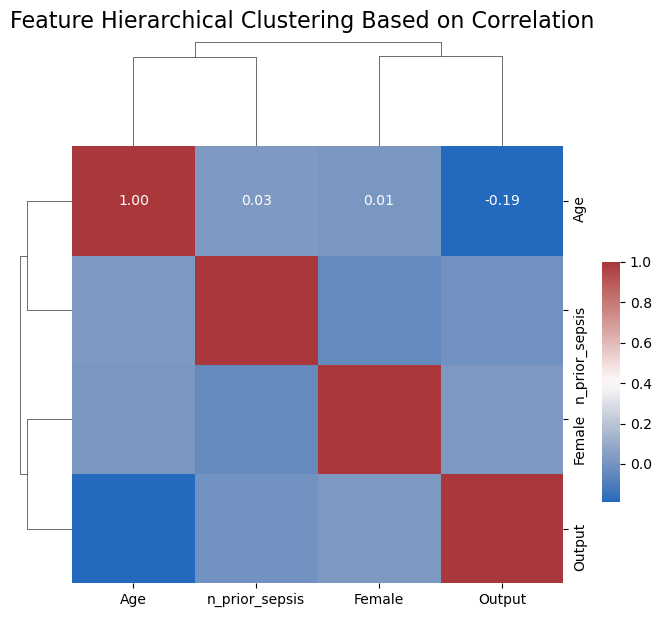

In [21]:
#Check correlation between the features and target using Hierarchical Clustering

corr_df = df_train.corr()

g = sns.clustermap(
    corr_df,
    method='ward',      # Standard method for hierarchical clustering
    cmap="vlag",        # Divergent colormap (better for correlation)
    figsize=(6, 6),
    annot=True,         # Show the correlation values
    fmt=".2f",
    dendrogram_ratio=(0.1, 0.2),
    cbar_pos=(1.0, 0.2, 0.03, 0.4)
)
g.fig.suptitle("Feature Hierarchical Clustering Based on Correlation", y=1.02, fontsize=16)
plt.show()

<h4>Output and Age</h4>

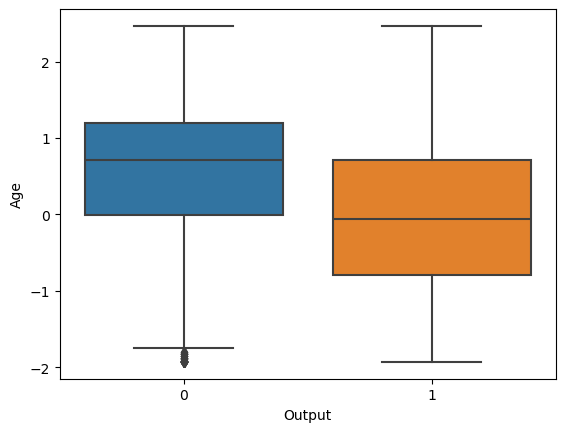

In [22]:
#Since Age and Output are negatively correlated, let's check the interaction visualy using boxplot.

sns.boxplot(x="Output",y="Age",data=df_train)
plt.show()

<p>Higher Age is related to lower mortality (Class 0).

<h3>Interaction Check using Logistic Regression</h3>

<p>Testing for feature synergy is crucial for both model accuracy and medical insight. An additive relationship means the combined risk is simply the sum of individual factor risks. 
<p>However, a synergistic relationship indicates the combined risk is significantly greater than the sum, revealing a dangerous interaction. 
<p>By using Logistic Regression to test the interaction term's, I statistically quantify this non-additive risk. Identifying synergy is key to predictive modeling because it necessitates including the interaction term to accurately forecast extreme outcomes, and clinically, it highlights specific high-risk patient subgroups needing simultaneous management of co-occurring conditions.

In [23]:
#define parameters

target = "Output"
df_columns = df_train.columns
len_list = len(df_columns)
    

In [24]:
#check each interactions: synergetic/antagonistic or additive

i=0
additive_interaction =[]
synergistic_interaction_positiv =[]
antagonistic_interaction = []
no_effect =[]

#this loop chooses a start feature
while i < len_list: 

    feature_a = df_columns[i]
    ii = i+1

    #interactions between feature_a and other features with index > their own index on df_columns list
    while ii < len_list:
        
        feature_b = df_columns[ii]
        interaction = feature_a+':'+feature_b #interaction string for formula
        formula = target+' ~ '+feature_a+' + '+feature_b+' + '+ interaction 
        
        # Determine if the interaction term (A * B) is degenerate (all zeros)
        # Ensure the columns are treated as integers (0 or 1) for multiplication
        interaction_data_sum = (df_train[feature_a].astype(int) * df_train[feature_b].astype(int)).sum()
        
        if interaction_data_sum == 0:
            # If the sum is 0, the features never co-occur. 
            # The matrix would be singular, so we skip the model fit and classify as additive.
            additive_interaction.append(interaction + " - Skipped (Never Co-occur)")
            ii = ii + 1 
            continue # Skip to the next iteration
            
        try:
            # Fit the Logistic Regression model
            # disp=False suppresses the iteration output during fitting
            model = logit(formula=formula, data=df_train).fit(disp=False) 

            # Use .summary2() to get a more structured summary object
            # Logit uses the z-statistic, so we look for "P>|z|"
            results_as_df_ = model.summary2().tables[1]

            #add interaction in the respectiv list, according to their type
            if results_as_df_.loc[interaction,"P>|z|"] < 0.05:

                if results_as_df_.loc[interaction,"P>|z|"] < 0.01:
                    level = " - Strong Interaction"
                else:
                    level = ""

                # Check the coefficient sign for synergistic or antagonistic effect
                if results_as_df_.loc[interaction,"Coef."] < 0:
                    antagonistic_interaction.append(interaction+level)
                elif results_as_df_.loc[interaction,"Coef."] > 0:
                    synergistic_interaction_positiv.append(interaction+level)
            else:
                additive_interaction.append(interaction) # Not significant (additive)
                
        except sm.tools.sm_exceptions.PerfectSeparationError:
             # This error occurs if the features perfectly predict the target (e.g., A=1, B=1 always means Target=1)
             additive_interaction.append(interaction + " - Skipped (Perfect Separation)")
        
        except Exception as e:
            # Catch other potential errors, including rare LinAlgError cases not caught by the sum check
            print(f"Error processing {interaction}: {e}")
            additive_interaction.append(interaction + " - Skipped (Error)")

        ii = ii + 1 
        
    i = i+1


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Error processing Age:Output: Singular matrix


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/discrete/discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/anaconda3/lib/p

In [25]:
#print the lists

print("Synergistic Interaction + :",synergistic_interaction_positiv)
print("Antagonistic Interaction - :", antagonistic_interaction)
print("Additive Interaction: ",additive_interaction)

Synergistic Interaction + : ['Age:n_prior_sepsis - Strong Interaction']
Antagonistic Interaction - : []
Additive Interaction:  ['Age:Female', 'Age:Output - Skipped (Error)', 'Female:n_prior_sepsis', 'Female:Output', 'n_prior_sepsis:Output']


<p>In this dataset there is no Antagonistic Interaction.
<p>There are one strong Synergistic Interaction (Age x Number of prior Sepsis)

<h5>Creating New features</h5>

<p>In order to preserve Synergistic interaction and create new, non-linear features, I decided to combine features with strong Interactions.

In [26]:
#create new feature "Age_X_N_Sepsis"

#in Training Data
df_train["Age_X_N_Sepsis"] = df_train["Age"] * df_train["n_prior_sepsis"]

#in Test Data
df_test["Age_X_N_Sepsis"] = df_test["Age"] * df_test["n_prior_sepsis"]

In [27]:
#create new feature "Age_X_N_Sepsis" for balanced dataset

#in Training Data
df_train_balanced["Age_X_N_Sepsis"] = df_train_balanced["Age"] * df_train_balanced["n_prior_sepsis"]


----------------

<H2>Simple Baseline Models</h2>

<h3>Testing on Imbalanced Data</h3>

<p> To define a minimal accuracy baseline and explore simple models, I decided to start testing the models Logistic Regression and Decision tree.
<p> Considering the Data imbalance, I used the parameter class_weight.

In [28]:
#Preparing the data:

#Split the data into X and y

#Training Data
X_train = df_train.loc[:,["Age","Female","n_prior_sepsis","Age_X_N_Sepsis"]]
y_train = df_train.loc[:,"Output"]

#Test Data
X_test = df_test.loc[:,["Age","Female","n_prior_sepsis","Age_X_N_Sepsis"]]
y_test = df_test.loc[:,"Output"]

<h4>Logistic Regression</h4>

In [29]:
#Create the model

# Initialize the Logistic Regression model
log_reg = LogisticRegression(solver="lbfgs", max_iter=1000, class_weight='balanced', random_state=42)

# Train the model using the training data
log_reg.fit(X_train,y_train)

# Make predictions
log_reg_y_pred = log_reg.predict(X_test)

In [30]:
#Model evaluation

evaluations("Logistic Regression",log_reg_y_pred,y_test)

Overall Accuracy for Logistic Regression: 0.6056
Weighted Precision for Logistic Regression: 0.8736
Weighted Recall for Logistic Regression: 0.6056
Weighted F1-Score for Logistic Regression: 0.6892

-------------------- Confusion Matrix --------------------
Predicted:
   Actual 0  Actual 1
0      1540       800
1      9406     14133


<h4>Decision Tree</h4>

In [31]:
#Creating the model and making predictions

#Initialize Decision Tree
dt_classifier = DecisionTreeClassifier(class_weight='balanced',random_state=42)

#Fitting the model
dt_classifier.fit(X_train,y_train)

#Make predictions
dt_y_pred = dt_classifier.predict(X_test)

In [32]:
#Model Evaluation

evaluations("Decision Tree Classifier",dt_y_pred,y_test)

Overall Accuracy for Decision Tree Classifier: 0.5400
Weighted Precision for Decision Tree Classifier: 0.8786
Weighted Recall for Decision Tree Classifier: 0.5400
Weighted F1-Score for Decision Tree Classifier: 0.6324

-------------------- Confusion Matrix --------------------
Predicted:
   Actual 0  Actual 1
0      1732       608
1     11297     12242


<p>The initial testing on the Original Imbalanced Dataset confirms that the models may be strugling to learn from minority Class (Class 0). While Weighted Precision is high, the low Weighted Recall and F1-Scores strongly suggest the classifiers are defaulting to the Majority Class. 

<h3>Testing on Balanced Data</h3>

<p>Testing the Same models and KNN on balanced data.
<p>Since KNN works better with balanced data, I decided to test just with balanced data.

In [33]:
#use df_train_balanced for predictions

#split the Data in X and y:

#Training Data
X_train_balanced = df_train_balanced.loc[:,["Age","Female","n_prior_sepsis","Age_X_N_Sepsis"]]
y_train_balanced = df_train_balanced.loc[:,"Output"]


<h4>Logistic Regression</h4>

In [34]:
#Create the model

# Initialize the Logistic Regression model
log_reg2 = LogisticRegression(solver="lbfgs", max_iter=1000, random_state=42)

# Train the model using the training data
log_reg2.fit(X_train_balanced,y_train_balanced)

# Make predictions
log_reg_y_pred2 = log_reg2.predict(X_test)

#Model evaluation
evaluations("Logistic Regression",log_reg_y_pred2,y_test)

Overall Accuracy for Logistic Regression: 0.9096
Weighted Precision for Logistic Regression: 0.8273
Weighted Recall for Logistic Regression: 0.9096
Weighted F1-Score for Logistic Regression: 0.8665

-------------------- Confusion Matrix --------------------
Predicted:
   Actual 0  Actual 1
0         0      2340
1         0     23539


<h4>Decision Tree</h4>

In [35]:
#Creating the model and making predictions

#Initialize Decision Tree
dt_classifier2 = DecisionTreeClassifier(random_state=42)

#Fitting the model
dt_classifier2.fit(X_train_balanced,y_train_balanced)

#Make predictions
dt_y_pred2 = dt_classifier2.predict(X_test)

#Model Evaluation
evaluations("Decision Tree Classifier",dt_y_pred2,y_test)

Overall Accuracy for Decision Tree Classifier: 0.9096
Weighted Precision for Decision Tree Classifier: 0.8273
Weighted Recall for Decision Tree Classifier: 0.9096
Weighted F1-Score for Decision Tree Classifier: 0.8665

-------------------- Confusion Matrix --------------------
Predicted:
   Actual 0  Actual 1
0         0      2340
1         0     23539


<h4>K-Nearest Neighbors (KNN)</h4>

In [36]:
#Build the Model and make Pradictions

#initialize the model
knn_classifier2 = KNeighborsClassifier(n_neighbors=5)

#train the model
knn_classifier2.fit(X_train_balanced,y_train_balanced)

#make predictions
knn_y_pred2 = knn_classifier2.predict(X_test)

#Evaluations
evaluations("KNN",knn_y_pred2,y_test)


Overall Accuracy for KNN: 0.8959
Weighted Precision for KNN: 0.8418
Weighted Recall for KNN: 0.8959
Weighted F1-Score for KNN: 0.8642

-------------------- Confusion Matrix --------------------
Predicted:
   Actual 0  Actual 1
0        75      2265
1       430     23109


<p>The Logistic Regression and Decision Tree classifiers registered zero correct predictions for the Minority Class (Class 0), while KNN performed better when analysisng predictions paramethers.

-------------------

<h2>Complex Models</h2>

<p>In order to capture complex non linear interactions, I choose to test tree more models: 
<ul>
<li>Gradient Boosting Machines</li>
<li>Support Vector Machines</li>
<li>Random Forest Classifier</li>
</ul>

<h3>Testing on Original Data - Imbalanced</h4>

<h4>Gradient Boosting Machine</h4>

In [37]:
#Target distribution
Class1 = 91/100
Class0 = 9/100
weight_ratio = Class1 / Class0

#Initialize
xgb_clf = xgb.XGBClassifier(
    scale_pos_weight=weight_ratio, 
    eval_metric='logloss'
)
#train the model
xgb_clf.fit(X_train,y_train)

#make predictions
gb_y_pred = xgb_clf.predict(X_test)

#evaluations
evaluations("Gradient Boosting Classifier",gb_y_pred,y_test)

Overall Accuracy for Gradient Boosting Classifier: 0.9096
Weighted Precision for Gradient Boosting Classifier: 0.8273
Weighted Recall for Gradient Boosting Classifier: 0.9096
Weighted F1-Score for Gradient Boosting Classifier: 0.8665

-------------------- Confusion Matrix --------------------
Predicted:
   Actual 0  Actual 1
0         0      2340
1         0     23539


<h3>Support Vector Machine</h3>

In [38]:
#Initialize the model
svm_classifier = SVC(
    kernel='rbf',             
    gamma='scale',            
    C=1.0,                    
    class_weight='balanced',  
    random_state=42,
    )

#Train data
svm_classifier.fit(X_train,y_train)

#predictions
svm_y_pred = svm_classifier.predict(X_test)

#Evaluations
evaluations("Support Vector Machine",svm_y_pred,y_test)

Overall Accuracy for Support Vector Machine: 0.5390
Weighted Precision for Support Vector Machine: 0.8801
Weighted Recall for Support Vector Machine: 0.5390
Weighted F1-Score for Support Vector Machine: 0.6313

-------------------- Confusion Matrix --------------------
Predicted:
   Actual 0  Actual 1
0      1755       585
1     11345     12194


<h3>Random Forest Classifier</h3>

In [43]:
# Baseline Random Forest
rf = RandomForestClassifier(
    n_estimators=100,          
    max_depth=None,            
    class_weight='balanced',   
    random_state=42,
    n_jobs=-1
)

#train the model
rf.fit(X_train, y_train)

#make predictions
y_pred_rf = rf.predict(X_test)

#evaluations
evaluations("Random Forest",y_pred_rf,y_test)

Overall Accuracy for Random Forest: 0.5344
Weighted Precision for Random Forest: 0.8786
Weighted Recall for Random Forest: 0.5344
Weighted F1-Score for Random Forest: 0.6274

-------------------- Confusion Matrix --------------------
Predicted:
   Actual 0  Actual 1
0      1742       598
1     11450     12089


<p>Since Gradient Boosting failed on predicting Class 0, it probably overfitter Class 1.
<p>Although the SVM and Random Forest did not achieve high accuracy, their results indicate that they attempted to distinguish both classes instead of defaulting to the majority. However, the low recall shows that it still struggled to detect the minority class (class 0) effectively.

<h3>Testing on Balanced Data</h3>

<h4>Gradient Boosting</h4>

In [39]:
#Initialize
xgb_clf2 = xgb.XGBClassifier(
    eval_metric='logloss'
)
#train the model
xgb_clf2.fit(X_train_balanced,y_train_balanced)

#make predictions
gb_y_pred2 = xgb_clf2.predict(X_test)

#evaluations
evaluations("Gradient Boosting Classifier",gb_y_pred2,y_test)

Overall Accuracy for Gradient Boosting Classifier: 0.9096
Weighted Precision for Gradient Boosting Classifier: 0.8273
Weighted Recall for Gradient Boosting Classifier: 0.9096
Weighted F1-Score for Gradient Boosting Classifier: 0.8665

-------------------- Confusion Matrix --------------------
Predicted:
   Actual 0  Actual 1
0         0      2340
1         0     23539


<h4>Support Vector Machine</h4>

In [40]:
#Initialize the model
svm_classifier2 = SVC(
    kernel='rbf',             
    gamma='scale',            
    C=1.0,                      
    random_state=42,
    )

#Train data
svm_classifier2.fit(X_train_balanced,y_train_balanced)

#predictions
svm_y_pred2 = svm_classifier2.predict(X_test)

#Evaluations
evaluations("Support Vector Machine",svm_y_pred2,y_test)

Overall Accuracy for Support Vector Machine: 0.9096
Weighted Precision for Support Vector Machine: 0.8273
Weighted Recall for Support Vector Machine: 0.9096
Weighted F1-Score for Support Vector Machine: 0.8665

-------------------- Confusion Matrix --------------------
Predicted:
   Actual 0  Actual 1
0         0      2340
1         0     23539


<h3>Random Forest Classifier</h3>

In [45]:
# Baseline Random Forest
rf = RandomForestClassifier(
    n_estimators=100,          
    max_depth=None,               
    random_state=42,
    n_jobs=-1
)

#train the model
rf.fit(X_train_balanced, y_train_balanced)

#make predictions
y_pred_rf = rf.predict(X_test)

#evaluations
evaluations("Random Forest",y_pred_rf,y_test)

Overall Accuracy for Random Forest: 0.9096
Weighted Precision for Random Forest: 0.8273
Weighted Recall for Random Forest: 0.9096
Weighted F1-Score for Random Forest: 0.8665

-------------------- Confusion Matrix --------------------
Predicted:
   Actual 0  Actual 1
0         0      2340
1         0     23539


<p>Gradient Boosting keeps showing the same problem.
<p>In this case, SVM and Random Forest failed to predict Class 0.

<h4>Quick analysis</h4>
<p>Several models trained on the original imbalanced dataset failed to predict any instances of the minority class (class 0). The confusion matrix confirms that all actual class 0 samples were misclassified as class 1, while some class 1 samples were incorrectly predicted as class 0. <p>Therefore, KNN showed the best performace learning with balanced data. 

-----------

<h2>Hyperparameter Optimization (Grid Search)</h2>

<p>To select the best parameters I choose following models:
<ul>
<li>KNN with balanced data: Best performace on first test.</li>
<li>Logistic Regression, Decision Tree and Random Forest with imbalanced data: Although it presented a low recall and f1-score, when trained with the original data, the model made some predictions for class 0, some of which were correct.</li>
</ul>

In [46]:
#importing libraries
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, f1_score, balanced_accuracy_score


<h3>KNN:</h3>

In [47]:

param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan'],
    'p': [1, 2]
}

grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_grid,
    scoring='f1_weighted',   
    cv=5,
    n_jobs=-1
)

grid_knn.fit(X_train_balanced, y_train_balanced) #train with balanced data

print("Best Parameters:", grid_knn.best_params_)
print("Best Score:", grid_knn.best_score_)
best_knn = grid_knn.best_estimator_

# Evaluate on test set
y_pred = best_knn.predict(X_test)

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=4))

# Check
f1 = f1_score(y_test, y_pred, average='weighted')
bal_acc = balanced_accuracy_score(y_test, y_pred)
print("Weighted F1:", f1)
print("Balanced Accuracy:", bal_acc)

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best Score: 0.3814297560022005
[[  157  2183]
 [  849 22690]]
              precision    recall  f1-score   support

           0     0.1561    0.0671    0.0938      2340
           1     0.9122    0.9639    0.9374     23539

    accuracy                         0.8828     25879
   macro avg     0.5341    0.5155    0.5156     25879
weighted avg     0.8439    0.8828    0.8611     25879

Weighted F1: 0.8610984641747974
Balanced Accuracy: 0.5155131073617416


<p>High global F1 but terrible balance — it’s overpredicting the majority class despite SMOTE. Likely underfits the minority cluster or overfits synthetic noise.

<h3>Logistic Regression</h3>

In [63]:
param_grid_lr = {
    'penalty': ['l2', 'none'],     
    'C': [0.01, 0.1, 1, 10, 100],  
    'solver': ['lbfgs', 'liblinear'],  # Optimization algorithm
    'class_weight': ['balanced'] #Since Data is imbalanced
}

grid_lr = GridSearchCV(
    estimator=LogisticRegression(max_iter=2000, random_state=42),
    param_grid=param_grid_lr,
    scoring='balanced_accuracy',  # better for imbalance
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_lr.fit(X_train, y_train)

print("Best Parameters (LR):", grid_lr.best_params_)
print("Best Balanced Accuracy (CV):", grid_lr.best_score_)

best_lr = grid_lr.best_estimator_

y_pred_lr = best_lr.predict(X_test)
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr, digits=4))
print("Weighted F1:", f1_score(y_test, y_pred_lr, average='weighted'))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_lr))


Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To kee

Best Parameters (LR): {'C': 0.01, 'class_weight': 'balanced', 'penalty': 'none', 'solver': 'lbfgs'}
Best Balanced Accuracy (CV): 0.6372486881949744
[[ 1540   800]
 [ 9406 14133]]
              precision    recall  f1-score   support

           0     0.1407    0.6581    0.2318      2340
           1     0.9464    0.6004    0.7347     23539

    accuracy                         0.6056     25879
   macro avg     0.5436    0.6293    0.4833     25879
weighted avg     0.8736    0.6056    0.6892     25879

Weighted F1: 0.6892441507739405
Balanced Accuracy: 0.6292637459636907


<p>'penalty'= 'none': This setting indicates that the LR model was fitted without a regularization term (λ). This suggests that a simple, unconstrained linear model was sufficient and that adding L1 (Lasso) or L2 (Ridge) penalties did not improve performance. It may happen because there are just few features avaliable in this model.
<p>'C'= 0.01: Since penalty is set to 'none', the C parameter (which is the inverse of the regularization strength λ) becomes functionally irrelevant.

<p>Moderate performance, slightly more balanced, but not great overall — it’s learning some minority structure but not enough.

<h3>Decision Tree</h3>

In [60]:
param_grid_dt = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'class_weight': ['balanced']
}

grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid_dt,
    scoring='balanced_accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_dt.fit(X_train, y_train)

print("Best Parameters (DT):", grid_dt.best_params_)
print("Best Balanced Accuracy (CV):", grid_dt.best_score_)

best_dt = grid_dt.best_estimator_

y_pred_dt = best_dt.predict(X_test)
print(confusion_matrix(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt, digits=4))
print("Weighted F1:", f1_score(y_test, y_pred_dt, average='weighted'))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_dt))


Fitting 5 folds for each of 135 candidates, totalling 675 fits
Best Parameters (DT): {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Balanced Accuracy (CV): 0.638830003441795
[[ 1854   486]
 [12480 11059]]
              precision    recall  f1-score   support

           0     0.1293    0.7923    0.2224      2340
           1     0.9579    0.4698    0.6304     23539

    accuracy                         0.4990     25879
   macro avg     0.5436    0.6311    0.4264     25879
weighted avg     0.8830    0.4990    0.5935     25879

Weighted F1: 0.5935338266250173
Balanced Accuracy: 0.6310618711336669


<p>Decent recall for class 0 (~0.8), but weak for class 1 (~0.4).

<h3>Random Forest Classifier</h3>

<p>I decided to use Randomized Search for faster analysis.

In [62]:
param_grid_rf = {
    'n_estimators': np.arange(100, 501, 100),          
    'max_depth': [None, 5, 10,20,30],           
    'min_samples_split': [2, 5,10],          # minimum samples to split
    'min_samples_leaf': [1, 2, 5],            # minimum samples per leaf
    'max_features': ['sqrt', 'log2'],         # feature selection strategy
    'class_weight': ['balanced']        # handle imbalance
}

grid_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced_subsample',random_state=42),
    param_distributions=param_grid_rf,
    n_iter=10,                    # test only 10 random combos
    scoring='balanced_accuracy',  # fair metric for imbalance
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print("Best Parameters (RF):", grid_rf.best_params_)
print("Best Balanced Accuracy (CV):", grid_rf.best_score_)

best_rf = grid_rf.best_estimator_

# Evaluate tuned model
y_pred_best_rf = best_rf.predict(X_test)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_best_rf))

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best_rf, digits=4))

print("Weighted F1:", f1_score(y_test, y_pred_best_rf, average='weighted'))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred_best_rf))


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Parameters (RF): {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 5, 'class_weight': 'balanced'}
Best Balanced Accuracy (CV): 0.6411393457998578

Confusion Matrix:
[[ 1828   512]
 [12107 11432]]

Classification Report:
              precision    recall  f1-score   support

           0     0.1312    0.7812    0.2246      2340
           1     0.9571    0.4857    0.6444     23539

    accuracy                         0.5124     25879
   macro avg     0.5442    0.6334    0.4345     25879
weighted avg     0.8824    0.5124    0.6064     25879

Weighted F1: 0.6064129544679229
Balanced Accuracy: 0.6334293369469035


<p>Similar results to Decision Tree — ensemble reduces overfitting but doesn’t solve class imbalance.

<p>Between all those models, Logistic Regression shows better recall balance between both classes.
<p>Logistic Regression (with class_weight='balanced' and possible threshold tuning) is the most appropriate choice when false negatives are costly and model interpretability matters.

--------

<h2>Cross Validation</h2>

<p>The GBR model's performance may indicate a case of overfitting, to confirm this theory cross validation will be used.

In [68]:
# Define scoring metrics
scoring = {
    'recall_macro': make_scorer(recall_score, average='macro'),
    'f1_weighted': make_scorer(f1_score, average='weighted'),
    'roc_auc': 'roc_auc'
}

# StratifiedKFold ensures class balance across folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

#use the best LR model to validate
cv_results = cross_validate(best_lr, X_train, y_train, cv=cv, scoring=scoring)

print("Mean Recall (macro):", cv_results['test_recall_macro'].mean())
print("Mean Weighted F1:", cv_results['test_f1_weighted'].mean())
print("Mean ROC-AUC:", cv_results['test_roc_auc'].mean())

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Mean Recall (macro): 0.6370410970995458
Mean Weighted F1: 0.6945815581044149
Mean ROC-AUC: 0.692580011336308


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


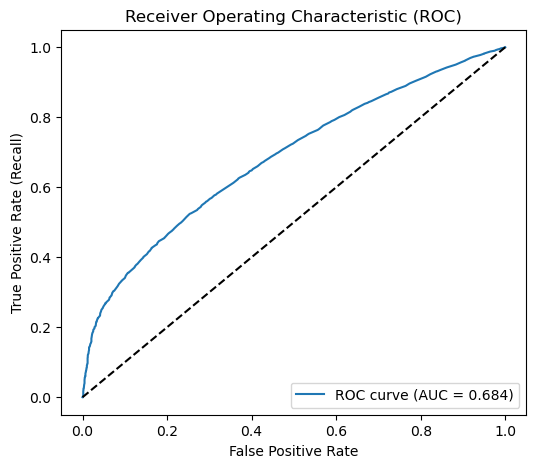

Test ROC-AUC: 0.6841103761969134


In [69]:
y_proba = best_lr.fit(X_train, y_train).predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print("Test ROC-AUC:", roc_auc)


<p>The Logistic Regression model demonstrates modest predictive power with a Mean ROC-AUC of approximately 0.693. Since this value is well above 0.5 but below the desired 0.7 threshold, the model is significantly better than random guessing but has limited ability to perfectly distinguish between positive and negative cases. The Mean Recall (macro) of 0.637 indicates the model correctly identifies about two-thirds of the true positive instances, suggesting it is moderately effective at capturing the target class. The Mean Weighted F1-Score of 0.695 confirms this balanced, moderate performance across both precision and recall. Overall, the model is a usable baseline but may require ajustments for higher performace. 

<h3>Precision Recall Curve</h3>

/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


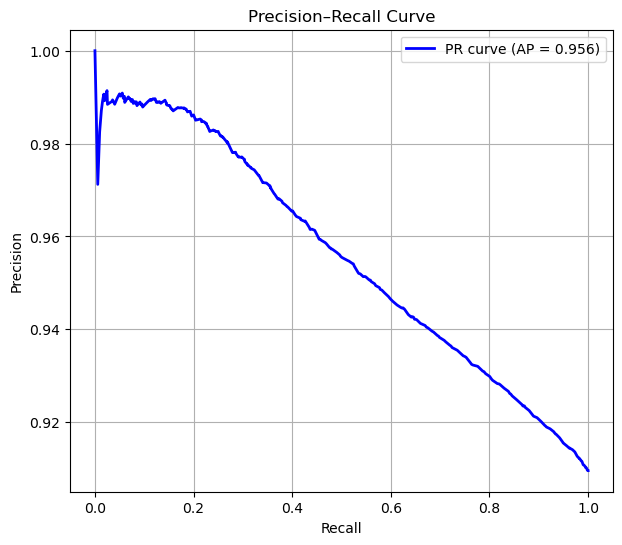

In [77]:
# Fit final model and get probabilities
best_lr.fit(X_train, y_train)
y_proba = best_lr.predict_proba(X_test)[:, 1]

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
avg_precision = average_precision_score(y_test, y_proba)

# Plot
plt.figure(figsize=(7, 6))
plt.plot(recall, precision, color='blue', linewidth=2, label=f'PR curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

<p>The Area Under the Precision-Recall Curve (AP) is the definitive metric for this imbalanced dataset, and its value of 0.956 demonstrates the model's high predictive power for the clinically critical minority class (patient mortality). The moderate ROC AUC (0.684) confirms the need to prioritize the PR AUC, as the ROC curve can be overly optimistic when one class vastly outnumbers the other.

-------------

<h2>Feature Importance</h2>

<p>Feature importance analysis is a requirement for building trust, ensuring safety, and driving clinical action in a healthcare application.
<p>It avoids Black Box decisions and provides transparency for users and stakeholders, once it validates domain knowledge and identifes unfair bias.

In [71]:
# Get the feature names
feature_names = X_train.columns

# Get the coefficients (betas)
coefficients = best_lr.coef_[0]

# Combine them into a DataFrame for easy viewing and sorting
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient (Beta)': coefficients,
    'Odds Ratio (exp(Beta))': np.exp(coefficients)
})

# Sort by the absolute magnitude of the coefficient to find the most 'important' features
feature_importance['Absolute_Coefficient'] = feature_importance['Coefficient (Beta)'].abs()
feature_importance = feature_importance.sort_values(
    by='Absolute_Coefficient', ascending=False
).reset_index(drop=True)

# Display the results
print("--- Logistic Regression Feature Importance ---")
print(feature_importance.to_markdown(index=False, floatfmt=".4f"))

--- Logistic Regression Feature Importance ---
| Feature        |   Coefficient (Beta) |   Odds Ratio (exp(Beta)) |   Absolute_Coefficient |
|:---------------|---------------------:|-------------------------:|-----------------------:|
| Age            |              -0.8731 |                   0.4177 |                 0.8731 |
| Age_X_N_Sepsis |               0.2936 |                   1.3412 |                 0.2936 |
| Female         |               0.2306 |                   1.2594 |                 0.2306 |
| n_prior_sepsis |              -0.2135 |                   0.8078 |                 0.2135 |


<p>Increasing Age significantly decreases the odds of the positive outcome (validated by strong negative interaction identifed previously)
<p>The effect of a prior sepsis event is much stronger/more positive for older patients. That means that, while overall, younger individuals in this cohort have a higher risk, the risk is significantly magnified due to the combined effect of Age and History of Sepsis.
<p>The coefficient for Famale could be biased, since the data is imbalanced and there is no equal sex distribution.

<p>Logistic Regression model was strategically chosen for its maximal interpretability, with the feature importance analysis confirming that Age (β=−0.8731) is the most significant negative predictor of survival, followed by the number of prior sepsis episodes and sex. 
<p>Although LR provides crucial clinical transparency and speed for bedside triage, the overall model performance metrics (Balanced Accuracy of 0.629 and Weighted F1-Score of 0.689) suggest limitations in its general predictive power across both classes. 
<p>Future work should focus on data augmentation by incorporating additional minimal clinical data, such as vital signs or simple lab values, and exploring more complex models to capture intricate non-linear relationships, aiming to significantly improve recall and overall accuracy.